In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 4.53 μs


In [7]:
# configuration settings

data_root = '/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene'
data_name = 'copdgene'
mask_roi = 'lung_regions'
mesh_version = 10

input_anat = True
input_coords = False

model_arch = 'unet3d'
num_levels = 3
num_conv_layers = 2
conv_channels = 32
conv_kernel_size = 3
output_func = 'relu'

trainer_task = 'train'
rho_value = 'anat'
interp_size = 5
interp_type = 'tent'
batch_size = 1
learning_rate = 1e-5
num_epochs = 200
test_every = 10
save_every = 10
save_prefix = '2024-02-24_miccai2025/asdf'

#save_prefix = f'2024-12-08__emory__clamp/train__emory__None__0__{rho_value}__{output_func}/'

In [8]:
project.utils.set_random_seed()

Setting random seed to 916767440


In [9]:
all_subjects = project.copdgene.COPDGene(data_root).subject_ids
bad_subjects = {
    '11771K', # no EXP image
    '12723E', # no EXP image
    '13990G', # no EXP image
    '14136Z', # no EXP image
    '15626V', # no EXP image
}
good_subjects = [x for x in all_subjects if x not in bad_subjects]

train_subjects = good_subjects[10:]
test_subjects = good_subjects[:10]
visit_names = ['Phase-1']

train_images = project.copdgene.COPDGene(data_root, train_subjects, visit_names)
test_images  = project.copdgene.COPDGene(data_root, test_subjects, visit_names)
train_images, test_images

(COPDGene(data_root=/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene, #subjects=100),
 COPDGene(data_root=/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene, #subjects=10))

In [10]:
%autoreload
train_examples = train_images.get_examples()
test_examples = test_images.get_examples()
for x in train_examples:
    for f in ['anat_file', 'disp_file', 'mask_file', 'mesh_file']:
        assert x[f].exists(), x[f]

In [11]:
%autoreload
train_data = project.data.Dataset(train_examples, image_scale=[1,1,4], cache_size=0)
test_data  = project.data.Dataset(test_examples,  image_scale=[1,1,4], cache_size=0)

In [12]:
device = 'cuda'
assert model_arch == 'unet3d'

model = project.model.UNet3D(
    in_channels=1*input_anat + 3*input_coords,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
    output_func=output_func,
).to(device)

In [13]:
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    rho_value=rho_value,
    interp_size=interp_size,
    interp_type=interp_type,
    test_every=test_every,
    save_every=save_every,
    save_prefix=save_prefix
)

In [14]:
load_epoch = 47
if load_epoch > 0:
    trainer.load_state(epoch=load_epoch)

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../project/training.py:547: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path)
/oc

In [15]:
%autoreload
j, batch = trainer.get_next_batch(phase='train')
batch[-1]

['18341U_INSP_STD_COL_COPD']

In [16]:
batch[0].shape

torch.Size([1, 1, 256, 256, 64])

In [29]:
%autoreload
import torch

def check_nan(**kwargs):
    for k, v in kwargs.items():
        assert not torch.isnan(v).any(), f'{v} contains nan'

# manual forward pass
a_image, e_image, u_image, mask, disease_mask, resolution, pde, name = batch

check_nan(a_image=a_image, e_image=e_image, u_image=u_image, mask=mask, disease_mask=disease_mask)

a_image = a_image.to(device)
e_image = e_image.to(device)
u_image = u_image.to(device)
mask = (mask > 0).to(device)

e_pred_image = model.forward(a_image) * 1000
e_pred_image = e_pred_image.clamp(min=1, max=1e12)

points = pde[0].points.to(device)
radius = pde[0].radius.to(device)

a_dofs = project.interpolation.interpolate_image(
    a_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

rho_dofs = (a_dofs + 1000)

e_pred_dofs = project.interpolation.interpolate_image(
    e_pred_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

u_true_dofs = project.interpolation.interpolate_image(
    u_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

check_nan(u_true_dofs=u_true_dofs, e_pred_dofs=e_pred_dofs, rho_dofs=rho_dofs)

u_pred_dofs = pde[0].forward(
    u_true_dofs[None,:,:],
    e_pred_dofs[None,:,0],
    rho_dofs[None,:,0]
)[0]

check_nan(u_pred_dofs=u_pred_dofs)

u_pred_dofs.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 47.43 GiB of which 19.69 MiB is free. Including non-PyTorch memory, this process has 47.40 GiB memory in use. Of the allocated memory 46.16 GiB is allocated by PyTorch, and 963.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(u_pred_dofs.numel())
print(u_pred_dofs.isnan().sum().item())

In [ ]:
e_pred_dofs[u_pred_dofs.isnan().any(dim=1)]

(14418,) (14418,) (14418,)


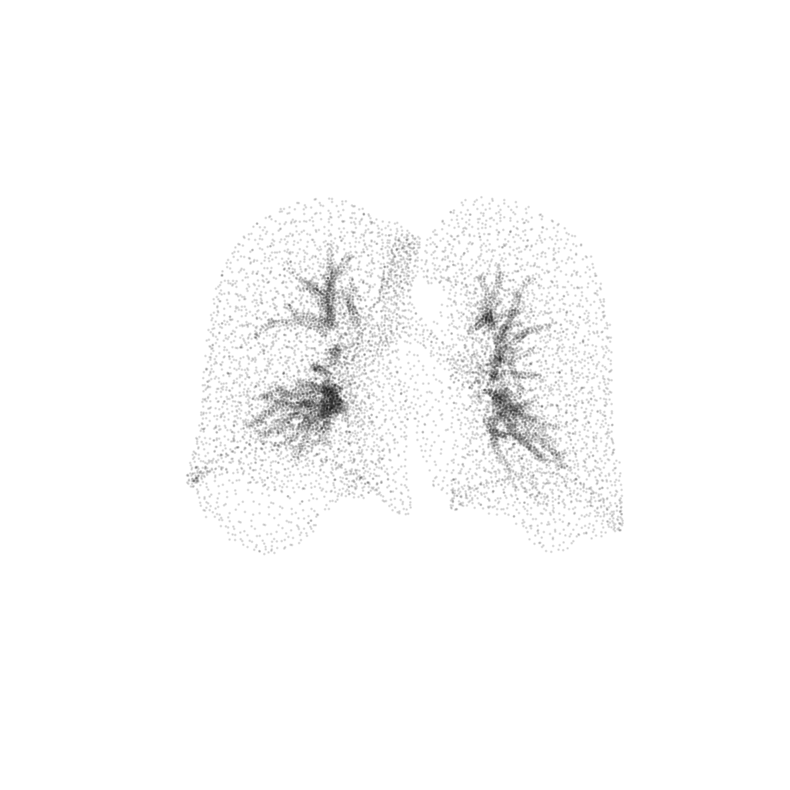

In [17]:
# plot nans

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde[0].points.detach().cpu().numpy()
x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

eps = 1e-6
values = u_pred_dofs.isnan().any(dim=-1).detach().cpu().numpy().astype(int)
normed = (values - values.min(axis=0)) / (values.max(axis=0) - values.min(axis=0) + eps)

c = normed * 1 + 0
s = normed * 5 + 1
a = normed * 0.9 + 0.1
print(c.shape, s.shape, a.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.scatter(x, y, z, c=c, cmap=project.visual.mre_color_map(symmetric=False), s=s, alpha=a)
ax.set_axis_off()

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

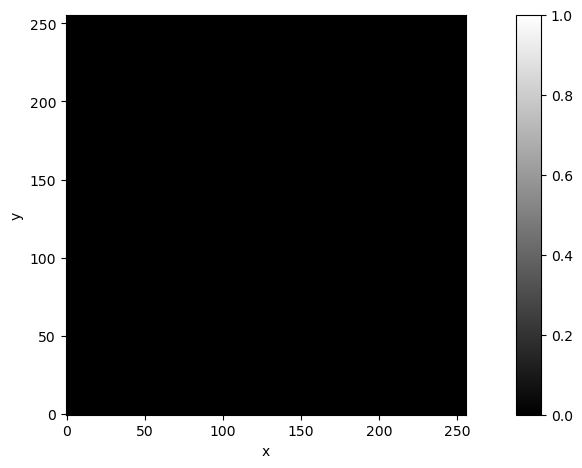

In [18]:
# view mask

project.visual.XArrayViewer(
    project.utils.as_xarray(mask[0,0], dims=['x', 'y', 'z'], name='mask')
)

[[0.77279162 0.1259783  0.78525525]
 [0.77027766 0.12632147 0.78395877]
 [0.77146459 0.13167461 0.7768537 ]
 ...
 [0.44365735 0.20883232 0.817451  ]
 [0.41682534 0.1947431  0.83269129]
 [0.43428798 0.20711754 0.83426343]]


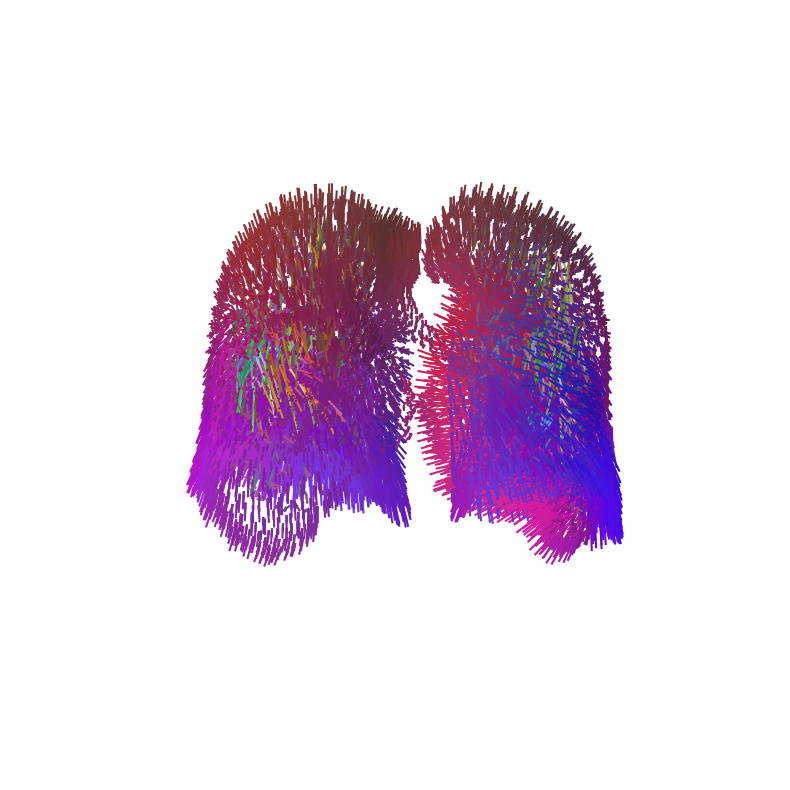

In [19]:
# plot dofs

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde[0].points.detach().cpu().numpy()
disp = u_pred_dofs.detach().cpu().numpy() * 1

x = coords[:,0]
y = coords[:,1]
z = coords[:,2]
u_x = disp[:,0]
u_y = disp[:,1]
u_z = disp[:,2]

c = (disp - disp.min(axis=0)) / (disp.max(axis=0) - disp.min(axis=0))
print(c)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.quiver(x, y, z, u_x, u_y, u_z, colors=c, arrow_length_ratio=0.5)
ax.set_axis_off()

1.0
[[1.07265892]
 [1.41980416]
 [0.79059855]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
[0.]
[[0.38986297]
 [0.51603456]
 [0.2873468 ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


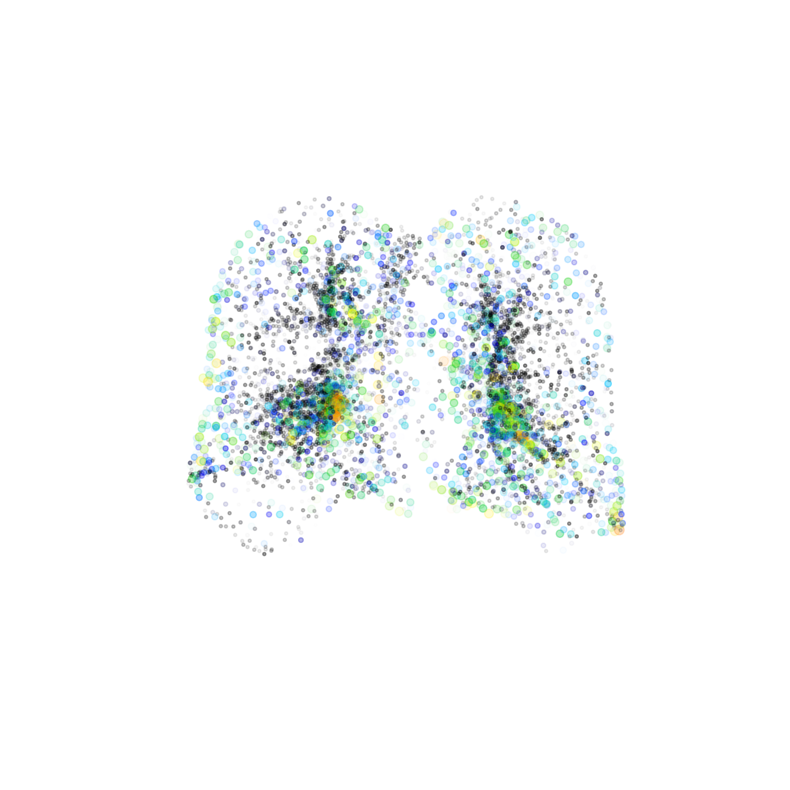

In [20]:
# plot dofs

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde[0].points.detach().cpu().numpy()
elast = e_pred_dofs.clamp(1, 1e12).detach().cpu().numpy()
print(elast.min())

log_e = np.log10(elast)
print(log_e)
print(log_e.min(axis=0))

x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

c = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0))
s = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0)) * 50 + 5
a = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0)) / 2
print(c)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.scatter(x, y, z, c=c, cmap=project.visual.mre_color_map(symmetric=False), s=s, alpha=a)
ax.set_axis_off()

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (1.3816100358963013, 1), (2.76322007…

0.00071149
CPU times: user 2min 20s, sys: 1.91 s, total: 2min 21s
Wall time: 2min 26s


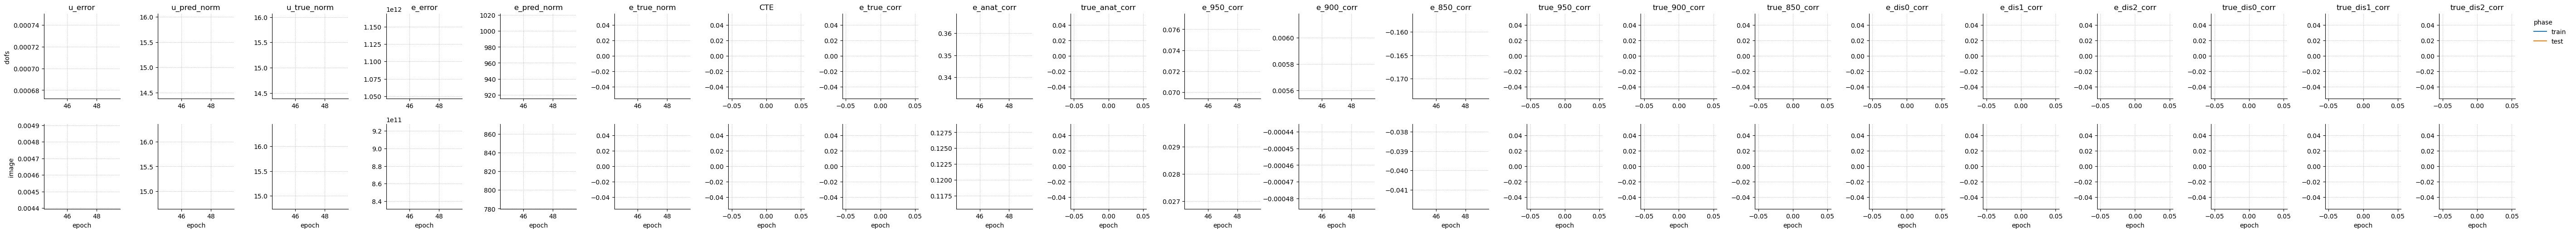

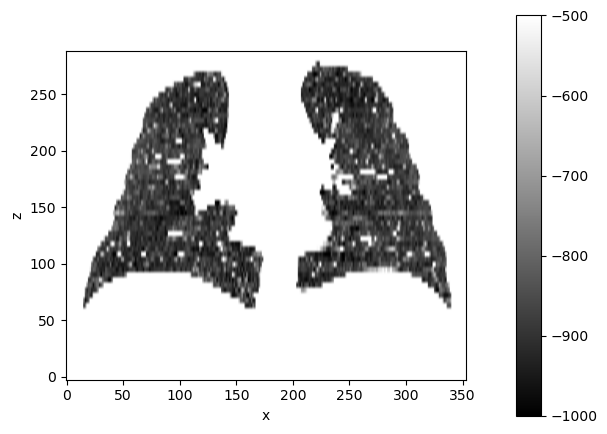

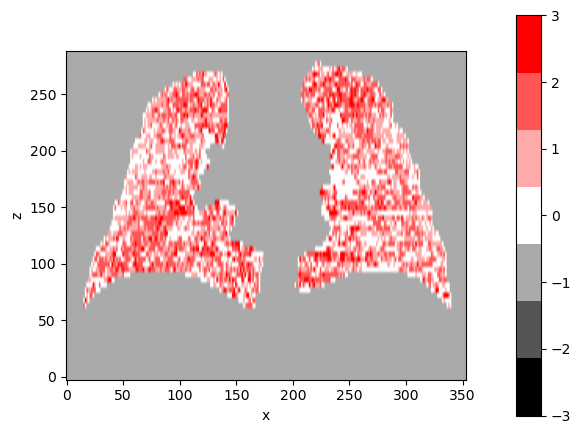

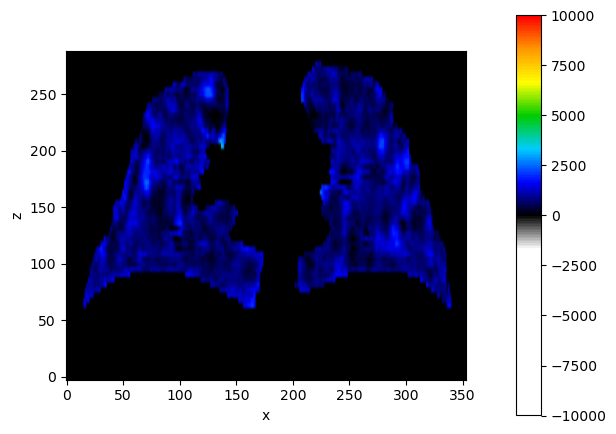

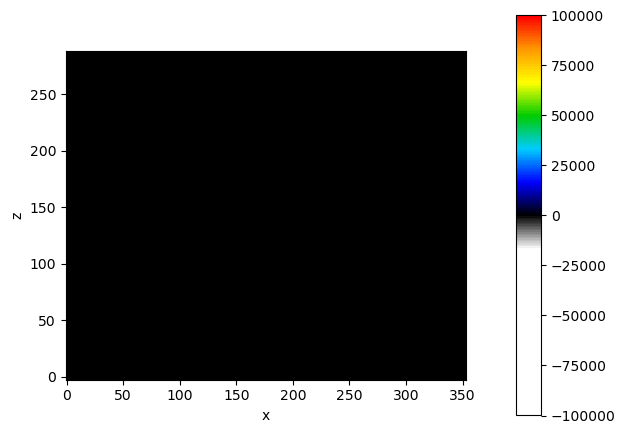

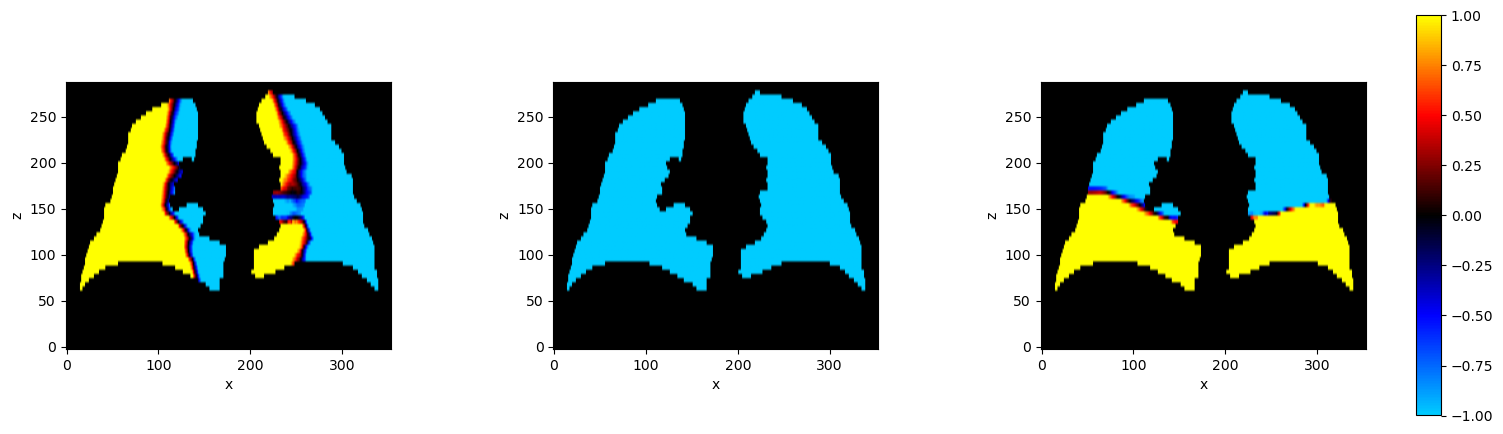

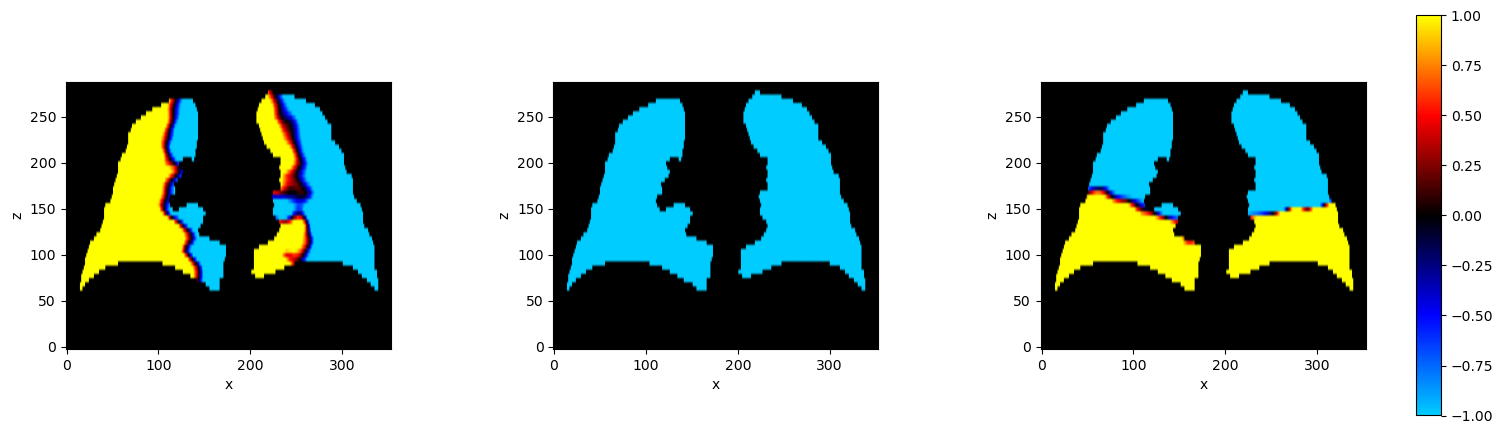

In [17]:
%%time
%autoreload
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=trainer.epoch)

In [14]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
%%time
trainer.timer.start()
trainer.train(num_epochs=250-load_epoch)

Training...
Epoch 48/250
Running train phase
['21737Q_INSP_B35f_UIA_COPD'].0.00018927
['15840X_EXP_STD_NJC_COPD'].0.00005344
['10896Z_INSP_STD_TXS_COPD'].0.00019184
['15053A_INSP_STD_UIA_COPD'].0.00315027
['11049P_INSP_STD_NJC_COPD'].0.00026395
['20102U_INSP_STD_NJC_COPD'].0.00313329
['13782Z_EXP_STD_UIA_COPD'].0.00049457
['25784T_EXP_STD_HAR_COPD'].0.00003052
['19497E_INSP_STD_MSM_COPD'].0.00018185
['15629B_INSP_STD_HPR_COPD'].0.00010661
['18732J_INSP_STD_UAB_COPD'].0.00100924
['23884N_EXP_B35f_UIA_COPD'].0.00042482
['25549J_EXP_STD_TEM_COPD'].0.00015369
['14293P_INSP_STD_PIT_COPD'].0.00011259
['22639V_INSP_STD_HAR_COPD'].0.00006531
['20528C_INSP_STD_BWH_COPD'].0.00007870
['23462N_EXP_STD_JHU_COPD'].0.00019074
['17102X_INSP_STD_DUK_COPD'].0.00004133
['20102U_EXP_STD_NJC_COPD'].0.00068836
['15053A_INSP_B35f_UIA_COPD'].0.00258486
['19132Q_INSP_STD_HAR_COPD'].0.00015926
['21589B_INSP_STD_TXS_COPD'].0.00012604
['23884N_EXP_STD_UIA_COPD'].0.00050566
['11705X_EXP_STD_TEM_COPD'].0.00008387
[

In [15]:
trainer.evaluator.metrics

u_error u_pred_norm  \
epoch batch example                  phase rep                           
20    1     10285W_EXP_STD_USD_COPD  test  dofs   0.000332   23.466847   
                                           image  0.002566   21.642482   
21    1     11919Q_INSP_STD_PIT_COPD train dofs   0.000271   19.890461   
      2     11705X_EXP_STD_TEM_COPD  train dofs   0.000088   24.488964   
      3     25881R_INSP_STD_MSM_COPD train dofs   0.000404    6.721641   
...                                                    ...         ...   
48    32    12360U_INSP_STD_UAB_COPD train dofs   0.000615   23.929834   
      33    22650J_INSP_STD_TEM_COPD train dofs   0.000194   22.047652   
      34    19648Z_INSP_STD_NJC_COPD train dofs   0.001885   35.687398   
      35    11181P_INSP_STD_NJC_COPD train dofs   0.000318   22.054937   
      36    10618X_EXP_STD_UAB_COPD  train dofs   0.000133   14.978091   

                                                 u_true_norm  \
epoch batch example                  phase rep                 
20    1     10285W_EXP_STD_USD_COPD  test  dofs    23.489112   
                                           image   21.790665   
21    1     11919Q_INSP_STD_PIT_COPD train dofs    19.906979   
      2     11705X_EXP_STD_TEM_COPD  train dofs    24.496182   
      3     25881R_INSP_STD_MSM_COPD train dofs     6.721633   
...                                                      ...   
48    32    12360U_INSP_STD_UAB_COPD train dofs    23.954592   
      33    22650J_INSP_STD_TEM_COPD train dofs    22.058656   
      34    19648Z_INSP_STD_NJC_COPD train dofs    35.754629   
      35    11181P_INSP_STD_NJC_COPD train dofs    22.070634   
      36    10618X_EXP_STD_UAB_COPD  train dofs    14.979732   

                                                               e_error  \
epoch batch example                  phase rep                           
20    1     10285W_EXP_STD_USD_COPD  test  dofs   1209464245360.086426   
                                           image       1354175348736.0   
21    1     11919Q_INSP_STD_PIT_COPD train dofs   1103111086770.449219   
      2     11705X_EXP_STD_TEM_COPD  train dofs   1345053205068.891846   
      3     25881R_INSP_STD_MSM_COPD train dofs   1789851644039.306396   
...                                                                ...   
48    32    12360U_INSP_STD_UAB_COPD train dofs   1256950390890.049316   
      33    22650J_INSP_STD_TEM_COPD train dofs   2046455129307.824951   
      34    19648Z_INSP_STD_NJC_COPD train dofs   1326993101461.234619   
      35    11181P_INSP_STD_NJC_COPD train dofs   1131738071149.815186   
      36    10618X_EXP_STD_UAB_COPD  train dofs   1794598811487.523438   

                                                  e_pred_norm e_true_norm  \
epoch batch example                  phase rep                              
20    1     10285W_EXP_STD_USD_COPD  test  dofs    1075.09525         0.0   
                                           image  1126.390503         0.0   
21    1     11919Q_INSP_STD_PIT_COPD train dofs   1018.796838         0.0   
      2     11705X_EXP_STD_TEM_COPD  train dofs   1123.259174         0.0   
      3     25881R_INSP_STD_MSM_COPD train dofs   1308.992619         0.0   
...                                                       ...         ...   
48    32    12360U_INSP_STD_UAB_COPD train dofs   1040.576125         0.0   
      33    22650J_INSP_STD_TEM_COPD train dofs   1374.352131         0.0   
      34    19648Z_INSP_STD_NJC_COPD train dofs   1004.563953         0.0   
      35    11181P_INSP_STD_NJC_COPD train dofs    974.892687         0.0   
      36    10618X_EXP_STD_UAB_COPD  train dofs   1280.612806         0.0   

                                                  CTE e_true_corr e_anat_corr  \
epoch batch example                  phase rep                                  
20    1     10285W_EXP_STD_USD_COPD  test  dofs   NaN         NaN   -0.029954   
                                           imag

In [16]:
trainer.timer.benchmarks

time  gpu_mem_total  \
epoch batch example phase event                                     
20    1     -1      test  get_next_batch  7.978073   5.092894e+10   
                          model_forward   0.346699   5.092894e+10   
             1      test  image_to_dofs   0.004227   5.092894e+10   
                          pde_forward     3.236200   5.092894e+10   
                          dof_metrics     1.382575   5.092894e+10   
...                                            ...            ...   
48    36     1      train image_to_dofs   0.006227   5.092894e+10   
                          pde_forward     4.625225   5.092894e+10   
                          dof_metrics     0.819130   5.092894e+10   
            -1      train loss_backward   4.810094   5.092894e+10   
                          optimizer_step  0.008688   5.092894e+10   

                                          gpu_mem_reserved  gpu_mem_allocated  \
epoch batch example phase event                                                 
20    1     -1      test  get_next_batch      2.090231e+10       1.699994e+07   
                          model_forward       2.090231e+10       1.242707e+10   
             1      test  image_to_dofs       2.090441e+10       1.324525e+10   
                          pde_forward         2.090441e+10       1.324525e+10   
                          dof_metrics         2.090441e+10       1.324525e+10   
...                                                    ...                ...   
48    36     1      train image_to_dofs       3.676098e+10       1.338497e+10   
                          pde_forward         3.676098e+10       1.338497e+10   
                          dof_metrics         3.676098e+10       1.338497e+10   
            -1      train loss_backward       3.676098e+10       2.040960e+08   
                          optimizer_step      3.676098e+10       1.984348e+08   

                                             mem_total      mem_used  
epoch batch example phase event                                       
20    1     -1      test  get_next_batch  5.408796e+11  1.281892e+09  
                          model_forward   5.408796e+11  1.489002e+09  
             1      test  image_to_dofs   5.408796e+11  1.587073e+09  
                          pde_forward     5.408796e+11  1.648755e+09  
                          dof_metrics     5.408796e+11  1.670623e+09  
...                                                ...           ...  
48    36     1      train image_to_dofs   5.408796e+11  3.316584e+09  
                          pde_forward     5.408796e+11  3.316584e+09  
                          dof_metrics     5.408796e+11  3.316584e+09  
            -1      train loss_backward   5.408796e+11  3.316589e+09  
                          optimizer_step  5.408796e+11  3.316589e+09  

[42647 rows x 6 columns]

In [17]:
trainer.timer.benchmarks.groupby(['phase', 'event']).mean().sort_values('time')

time  gpu_mem_total  gpu_mem_reserved  \
phase event                                                         
test  image_to_dofs     0.004260   5.092894e+10      3.279631e+10   
train image_to_dofs     0.004778   5.092894e+10      3.675482e+10   
      optimizer_step    0.007890   5.092894e+10      3.675482e+10   
      model_forward     0.034634   5.092894e+10      3.675482e+10   
test  model_forward     0.103574   5.092894e+10      3.279579e+10   
      save_state        0.359346   5.092894e+10      3.676090e+10   
train dof_metrics       0.773147   5.092894e+10      3.675482e+10   
test  dof_metrics       1.002821   5.092894e+10      3.279631e+10   
      update_viewers    1.389234   5.092894e+10      3.279631e+10   
      image_metrics     1.487947   5.092894e+10      3.279631e+10   
train pde_forward       2.176441   5.092894e+10      3.675482e+10   
      loss_backward     2.281477   5.092894e+10      3.675482e+10   
test  pde_forward       2.438408   5.092894e+10      3.279631e+10   
train get_next_batch    7.458985   5.092894e+10      3.675482e+10   
test  get_next_batch    7.532856   5.092894e+10      3.279579e+10   
      dofs_to_image   126.100476   5.092894e+10      3.279631e+10   

                      gpu_mem_allocated     mem_total      mem_used  
phase event                                                          
test  image_to_dofs        1.309373e+10  5.408796e+11  2.733574e+09  
train image_to_dofs        1.301239e+10  5.408796e+11  3.273564e+09  
      optimizer_step       1.980632e+08  5.408796e+11  3.276657e+09  
      model_forward        1.243559e+10  5.408796e+11  3.273636e+09  
test  model_forward        1.243346e+10  5.408796e+11  2.709057e+09  
      save_state           2.551962e+07  5.408796e+11  3.168588e+09  
train dof_metrics          1.301239e+10  5.408796e+11  3.276452e+09  
test  dof_metrics          1.309373e+10  5.408796e+11  2.771997e+09  
      update_viewers       1.331396e+10  5.408796e+11  2.865929e+09  
      image_metrics        1.328041e+10  5.408796e+11  2.808977e+09  
train pde_forward          1.301239e+10  5.408796e+11  3.277355e+09  
      loss_backward        2.037243e+08  5.408796e+11  3.276674e+09  
test  pde_forward          1.309373e+10  5.408796e+11  2.766518e+09  
train get_next_batch       2.551962e+07  5.408796e+11  3.273673e+09  
test  get_next_batch       2.338970e+07  5.408796e+11  2.657279e+09  
      dofs_to_image        1.327828e+10  5.408796e+11  2.786294e+09

In [18]:
trainer.timer.benchmarks.reset_index()

,epoch,batch,example,phase,event,time,gpu_mem_total,gpu_mem_reserved,gpu_mem_allocated,mem_total,mem_used
0,20,1,-1,test,get_next_batch,7.978073,5.092894e+10,2.090231e+10,1.699994e+07,5.408796e+11,1.281892e+09
1,20,1,-1,test,model_forward,0.346699,5.092894e+10,2.090231e+10,1.242707e+10,5.408796e+11,1.489002e+09
2,20,1,1,test,image_to_dofs,0.004227,5.092894e+10,2.090441e+10,1.324525e+10,5.408796e+11,1.587073e+09
3,20,1,1,test,pde_forward,3.236200,5.092894e+10,2.090441e+10,1.324525e+10,5.408796e+11,1.648755e+09
4,20,1,1,test,dof_metrics,1.382575,5.092894e+10,2.090441e+10,1.324525e+10,5.408796e+11,1.670623e+09
...,...,...,...,...,...,...,...,...,...,...,...
42642,48,36,1,train,image_to_dofs,0.006227,5.092894e+10,3.676098e+10,1.338497e+10,5.408796e+11,3.316584e+09
42643,48,36,1,train,pde_forward,4.625225,5.092894e+10,3.676098e+10,1.338497e+10,5.408796e+11,3.316584e+09
42644,48,36,1,train,dof_metrics,0.819130,5.092894e+10,3.676098e+10,1.338497e+10,5.408796e+11,3.316584e+09
42645,48,36,-1,train,loss_backward,4.810094,5.092894e+10,3.676098e+10,2.040960e+08,5.408796e+11,3.316589e+09


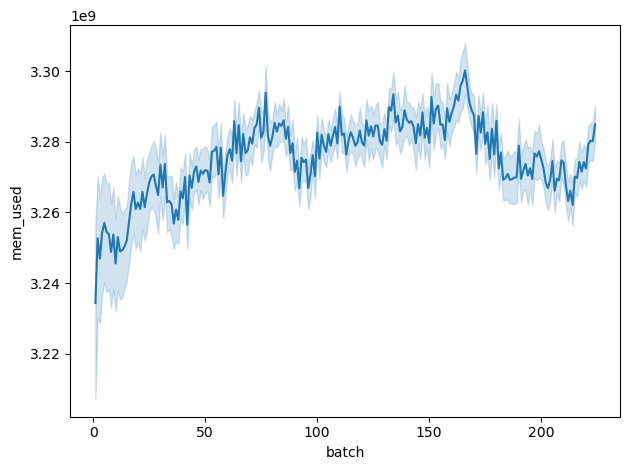

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

t = trainer.timer.benchmarks.reset_index()

fig, ax = plt.subplots()
sns.lineplot(t[t.phase == 'train'], y='mem_used', x='batch')
fig.tight_layout()

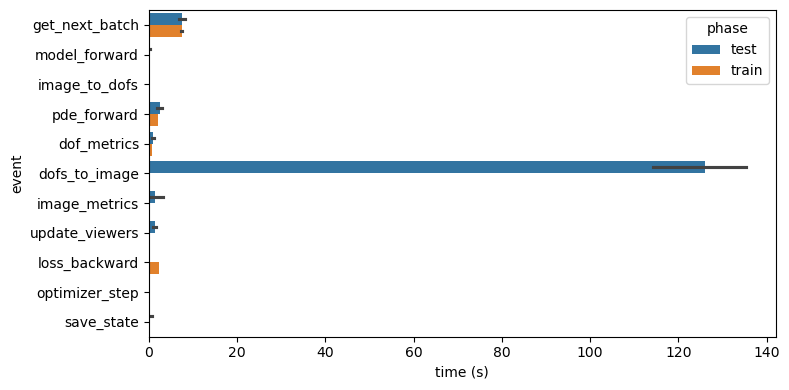

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.benchmarks, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

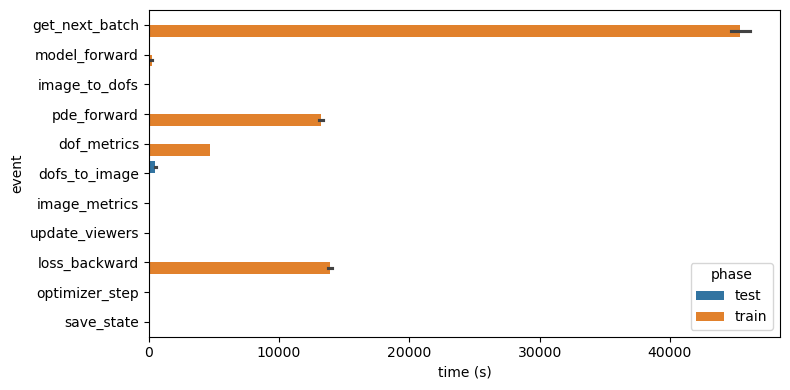

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.benchmarks , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

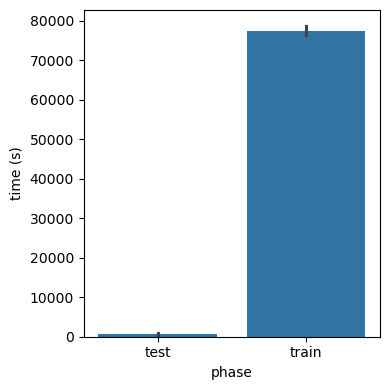

In [22]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.benchmarks, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [43]:
%autoreload
ex = train_data[0]
print('Done')

Loading NIFTI images
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10618X/Phase-1/Resized/10618X_EXP_STD_UAB_COPD.nii.gz... (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10618X/Phase-1/CorrField/10618X_EXP_STD_UAB_COPD/10618X_INSP_STD_UAB_COPD.nii.gz... (256, 256, 256, 3)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10618X/Phase-1/TotalSegment/10618X_EXP_STD_UAB_COPD/lung_regions.nii.gz... (256, 256, 256)
Converting to tensors
Loading mesh from XDMF file
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/10618X/Phase-1/pygalmesh/10618X_EXP_STD_UAB_COPD/lung_regions_10.xdmf... 29631
Downsampling images
Initializing FEM model
Done


In [41]:
ex[-2].radius.device

device(type='cuda', index=0)